# Churn Analysis - Random Forest
The purpose of this analysis was to build a model to predict churn. Using Random Forest (RF), the goal was to build a model considering various customer attributes among 50 variables to accurately predict whether a customer would churn or not. The dataset contains 10,000 observations representing churned and unchurned customers. The first step will be exploring the data to find features that would work well with the model

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE, accuracy_score

# For plotting in the nb
import matplotlib.pyplot as plt
%matplotlib inline 

In [12]:
# Reading in the data
data = pd.read_csv("C:\\Users\Owner\Desktop\School\Data Mining D209\Task 1\churn_clean.csv")
data.head()

,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,...,MonthlyCharge,Bandwidth_GB_Year,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,K409198,aa90260b-4141-4a24-8e36-b04ce1f4f77b,e885b299883d4f9fb18e39c75155d990,Point Baker,AK,Prince of Wales-Hyder,99927,56.25100,-133.37571,...,172.455519,904.536110,5,5,5,3,4,4,3,4
1,2,S120509,fb76459f-c047-4a9d-8af9-e0f7d4ac2524,f2de8bef964785f41a2959829830fb8a,West Branch,MI,Ogemaw,48661,44.32893,-84.24080,...,242.632554,800.982766,3,4,3,3,4,3,4,4
2,3,K191035,344d114c-3736-4be5-98f7-c72c281e2d35,f1784cfa9f6d92ae816197eb175d3c71,Yamhill,OR,Yamhill,97148,45.35589,-123.24657,...,159.947583,2054.706961,4,4,2,4,4,3,3,3
3,4,D90850,abfa2b40-2d43-4994-b15a-989b8c79e311,dc8a365077241bb5cd5ccd305136b05e,Del Mar,CA,San Diego,92014,32.96687,-117.24798,...,119.956840,2164.579412,4,4,4,2,5,4,3,3
4,5,K662701,68a861fd-0d20-4e51-a587-8a90407ee574,aabb64a116e83fdc4befc1fbab1663f9,Needville,TX,Fort Bend,77461,29.38012,-95.80673,...,149.948316,271.493436,4,4,4,3,4,4,4,5


In [13]:
# Removing: Id columns, Geographic data (City, State, County, Zip)

data=data.drop(['CaseOrder','Customer_id','Interaction','UID','City','State','County','Zip','Lat','Lng','TimeZone','Job'],1)
data=data.drop(['Population','Children','Income','Marital','Gender','Area','Age'],1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Churn                 10000 non-null  object 
 1   Outage_sec_perweek    10000 non-null  float64
 2   Email                 10000 non-null  int64  
 3   Contacts              10000 non-null  int64  
 4   Yearly_equip_failure  10000 non-null  int64  
 5   Techie                10000 non-null  object 
 6   Contract              10000 non-null  object 
 7   Port_modem            10000 non-null  object 
 8   Tablet                10000 non-null  object 
 9   InternetService       10000 non-null  object 
 10  Phone                 10000 non-null  object 
 11  Multiple              10000 non-null  object 
 12  OnlineSecurity        10000 non-null  object 
 13  OnlineBackup          10000 non-null  object 
 14  DeviceProtection      10000 non-null  object 
 15  TechSupport         

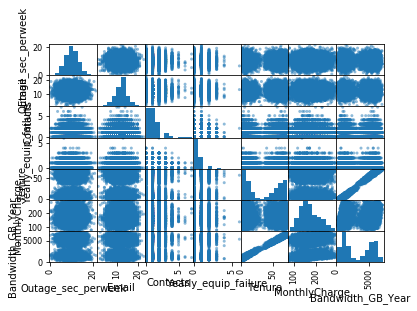

In [14]:
# Analyzing relationships between the continuous variables
cont_data = data[['Outage_sec_perweek','Email','Contacts','Yearly_equip_failure','Tenure','MonthlyCharge','Bandwidth_GB_Year']]
pd.plotting.scatter_matrix(cont_data)

plt.show()

The results show a strong positive linear relationship between Tenure and Bandwidth_GB_Year. There is also a mix of normal distributions, bimodal distributions (Tenure & Usage), and variables that are right skewed.

In [15]:
corr = cont_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Outage_sec_perweek,Email,Contacts,Yearly_equip_failure,Tenure,MonthlyCharge,Bandwidth_GB_Year
Outage_sec_perweek,1.00,0.00,0.02,0.00,0.00,0.02,0.00
Email,0.00,1.00,0.00,-0.02,-0.01,0.00,-0.01
Contacts,0.02,0.00,1.00,-0.01,0.00,0.00,0.00
Yearly_equip_failure,0.00,-0.02,-0.01,1.00,0.01,-0.01,0.01
Tenure,0.00,-0.01,0.00,0.01,1.00,-0.00,0.99
MonthlyCharge,0.02,0.00,0.00,-0.01,-0.00,1.00,0.06
Bandwidth_GB_Year,0.00,-0.01,0.00,0.01,0.99,0.06,1.00


The correlation plot confirms the same about Tenure and Bandwidth_GB_Year showing essentially a 100% correlation. Because of this, Bandwidth_GB_Year will be kept and Tenure will be dropped so the model doesn't get confused from the multicollinearity.

In [16]:
# Dropping Tenure
data=data.drop(['Tenure'],1)

The next step was to convert the categorical variables into dummy columns since kNN only accepts numeric data types

In [17]:
# Converting survey questions to strings so they're recognized as categorical columns
data[['Item1','Item2','Item3','Item4','Item5','Item6','Item7','Item8']] = data[['Item1','Item2','Item3','Item4','Item5','Item6','Item7','Item8']].astype(str)

# Creating dummies
data = pd.get_dummies(data, drop_first = True)
data.head()

,Outage_sec_perweek,Email,Contacts,Yearly_equip_failure,MonthlyCharge,Bandwidth_GB_Year,Churn_Yes,Techie_Yes,Contract_One year,Contract_Two Year,...,Item7_5,Item7_6,Item7_7,Item8_2,Item8_3,Item8_4,Item8_5,Item8_6,Item8_7,Item8_8
0,7.978323,10,0,1,172.455519,904.536110,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,11.699080,12,0,1,242.632554,800.982766,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,10.752800,9,0,1,159.947583,2054.706961,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3,14.913540,15,2,0,119.956840,2164.579412,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
4,8.147417,16,2,1,149.948316,271.493436,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Looking at the relationships between categorical variables

In [18]:
catg_data = data.iloc[:,6:]
corr = catg_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

The output is large but the following correlations can be observed with churn:<br><br>StreamingMovies = 29%<br>StreamingTV = 23%<br>Multiple = 13%<br>Contract_Two_Year = -18%<br>Contract_One_Year = -14%<br><br>
Because the survery questions don't show any relationship with churn and the fact that including the variables greatly increases the number of features they will be dropped.

In [19]:
# Dropping the survey questions
data = data.loc[:, ~data.columns.str.startswith('Item')]

In [20]:
# Outputting the final dataset that will be used for model building
data.to_excel("C:\\Users\Owner\Desktop\School\Data Mining D209\Task 2\copy_of_the_cleaned_data_set.xlsx")

The data was separated by response and predictor variables and split into train and test (80%/20%). The four resulting datasets were written to excel files per the task requirement 

In [21]:
# Splitting the dataset by predictor and response
X = data.drop(['Churn_Yes'], axis=1)
y = data['Churn_Yes']

# 80% Train / 20% test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1111)

# Writing the datasets to an excel as required
X_train.to_excel("C:\\Users\Owner\Desktop\School\Data Mining D209\Task 2\copy_of_X_train.xlsx")
X_test.to_excel("C:\\Users\Owner\Desktop\School\Data Mining D209\Task 2\copy_of_X_test.xlsx")
y_train.to_excel("C:\\Users\Owner\Desktop\School\Data Mining D209\Task 2\copy_of_y_train.xlsx")
y_test.to_excel("C:\\Users\Owner\Desktop\School\Data Mining D209\Task 2\copy_of_y_test.xlsx")

The parameter grid was made, the RF model was called, and the model was fit

In [22]:
# Getting a grid of parameters for GridSearchCV
parameters = {'n_estimators': [300,400,500],
              'max_depth':[4,6,8],
              'min_samples_leaf': [0.1,0.2],
              'max_features': ['log2', 'sqrt']
             }


# Setting up RF
rf = RandomForestClassifier(random_state = 1111)

# Fitting the data using GridSearchCV with
grid_rf = GridSearchCV(rf, param_grid=parameters, cv=3, scoring='accuracy',verbose=1,n_jobs=-1)
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [23]:
# Getting the best hyperparameters
best_hyperparams = grid_rf.best_params_
print('Best hyperparameters:\n', best_hyperparams)

# Getting, from best model, the average of the 3 cross validated accuracy scores on the train data
print('Accuracy from cross validation was: {:.2f}'.format(grid_rf.best_score_))

# Getting the best model
best_model = grid_rf.best_estimator_

# Predict the test set labels
y_pred = best_model.predict(X_test)

# Print the test set MSE
print('Test set MSE of rf: {:.2f}'.format(MSE(y_test, y_pred)))

# Printing test data accuracy
print('Accuracy on the test data was: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Best hyperparameters:
 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'n_estimators': 400}
Accuracy from cross validation was: 0.78
Test set MSE of rf: 0.22
Accuracy on the test data was: 0.78


The best model had an ensemble of 400 trees. The Accuracy between cross validation and the test data was the same supporting that the model would generalize well on unseen data. MSE was low at 0.22 (for reference with a binary response like churn in this analysis: A model that is always right MSE = 0, A model that is always wrong MSE = 1). MSE = 1/observations * sum(y_pred-y_test)^2. In other words the MSE here is 1-the accuracy and vice versa

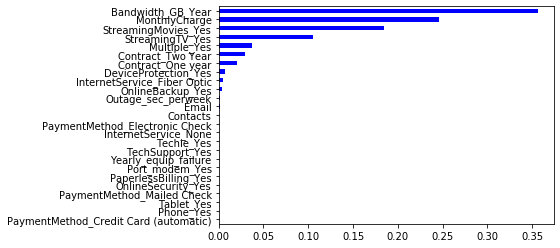

PaymentMethod_Credit Card (automatic)    0.000000
Phone_Yes                                0.000000
Tablet_Yes                               0.000000
PaymentMethod_Mailed Check               0.000018
OnlineSecurity_Yes                       0.000090
PaperlessBilling_Yes                     0.000179
Port_modem_Yes                           0.000191
Yearly_equip_failure                     0.000253
TechSupport_Yes                          0.000348
Techie_Yes                               0.000419
InternetService_None                     0.000659
PaymentMethod_Electronic Check           0.000666
Contacts                                 0.000705
Email                                    0.001148
Outage_sec_perweek                       0.001264
OnlineBackup_Yes                         0.003774
InternetService_Fiber Optic              0.005267
DeviceProtection_Yes                     0.006986
Contract_One year                        0.020187
Contract_Two Year                        0.029327


In [24]:
# Create a series for each feature's importance
imps_rf = pd.Series(best_model.feature_importances_, index = X.columns)

# Sorting by importance
sorted_imps_rf = imps_rf.sort_values()

# Horizontal bar plot
sorted_imps_rf.plot(kind='barh', color='blue'); plt.show()

sorted_imps_rf

The plot shows that most of the variables are not important in the model based on importance. The unimportant columns (importance < .01) will be dropped in order to acheive the best reduced model.

In [25]:
# Dropping the survey questions
data=data.drop(['PaymentMethod_Credit Card (automatic)',	'Phone_Yes',	'Tablet_Yes',	'PaymentMethod_Mailed Check',	'OnlineSecurity_Yes',	'PaperlessBilling_Yes',	'Port_modem_Yes',	'Yearly_equip_failure',	'TechSupport_Yes',	'Techie_Yes',	'InternetService_None',	'PaymentMethod_Electronic Check',	'Contacts',	'Email',	'Outage_sec_perweek',	'OnlineBackup_Yes',	'InternetService_Fiber Optic',	'DeviceProtection_Yes'
],1)

corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,MonthlyCharge,Bandwidth_GB_Year,Churn_Yes,Contract_One year,Contract_Two Year,Multiple_Yes,StreamingTV_Yes,StreamingMovies_Yes
MonthlyCharge,1.00,0.06,0.37,0.01,0.00,0.39,0.48,0.61
Bandwidth_GB_Year,0.06,1.00,-0.44,-0.00,0.02,0.01,0.05,0.05
Churn_Yes,0.37,-0.44,1.00,-0.14,-0.18,0.13,0.23,0.29
Contract_One year,0.01,-0.00,-0.14,1.00,-0.29,0.02,0.02,-0.00
Contract_Two Year,0.00,0.02,-0.18,-0.29,1.00,0.01,0.00,-0.01
Multiple_Yes,0.39,0.01,0.13,0.02,0.01,1.00,0.00,0.00
StreamingTV_Yes,0.48,0.05,0.23,0.02,0.00,0.00,1.00,-0.01
StreamingMovies_Yes,0.61,0.05,0.29,-0.00,-0.01,0.00,-0.01,1.00


Churned customers tend to have higher monthly charges, less usage, not have contracts, and use streaming services

In [26]:
# Splitting the dataset by predictor and response
X = data.drop(['Churn_Yes'], axis=1)
y = data['Churn_Yes']

# Getting a grid of parameters for GridSearchCV
parameters = {'n_estimators': [300,400,500],
              'max_depth':[4,6,8],
              'min_samples_leaf': [0.1,0.2],
              'max_features': ['log2', 'sqrt']
             }

# 80% Train / 20% test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1111)

# Setting up RF
rf = RandomForestClassifier(random_state = 1111)

# Fitting the data using GridSearchCV with
grid_rf = GridSearchCV(rf, param_grid=parameters, cv=3, scoring='accuracy',n_jobs=-1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [27]:
# Getting the best hyperparameters
best_hyperparams = grid_rf.best_params_
print('Best hyperparameters:\n', best_hyperparams)

# Getting, from best model, the average of the 3 cross validated accuracy scores on the train data
print('Accuracy from cross validation was: {:.2f}'.format(grid_rf.best_score_))

# Getting the best model
best_model = grid_rf.best_estimator_

# Predict the test set labels
y_pred = best_model.predict(X_test)

# Print the test set MSE
print('Test set MSE of rf: {:.2f}'.format(MSE(y_test, y_pred)))

# Printing test data accuracy
print('Accuracy on the test data was: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Best hyperparameters:
 {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'n_estimators': 400}
Accuracy from cross validation was: 0.82
Test set MSE of rf: 0.18
Accuracy on the test data was: 0.81


After dropping the columns there was a 3% gain in accuracy on the test data and MSE lowering to 0.18. The final model was reduced to 7 features with an accuracy of 81% on the test data and no signs of overfitting. 

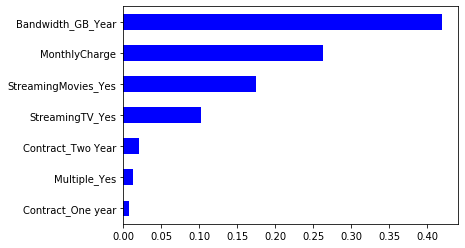

In [28]:
# Create a series for each feature's importance
imps_rf = pd.Series(best_model.feature_importances_, index = X.columns)

# Sorting by importance
sorted_imps_rf = imps_rf.sort_values()

# Horizontal bar plot
sorted_imps_rf.plot(kind='barh', color='blue'); plt.show()

The variables that had the largest impact on churn are listed above. Over half of the importance was taken up by usage and monthly charges followed by both streaming services. Based on correlations observed earlier churned customers tend to have less usage and have higher monthly charges compared to existing customers. An example of a way to keep customers is by offering deals to customers once their charges become high.